In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress
import os
from pathlib import Path
import re


def extract_fields_from_okc(file_path, fields):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Read header to get number of fields and points
    header = lines[0].strip()
    n_fields, n_points, foo = map(int, header.split())
    # Read field names in the next n_fields lines
    field_names = [line.strip() for line in lines[1:(n_fields + 1)]]

    # Data starts at line 2 * n_fields + 1
    start_data_lines = (2 * n_fields + 1)

    df = pd.read_csv(file_path, sep=r'\s+', skiprows=start_data_lines, names=field_names)
    sliced_df = df[fields]
    return sliced_df

def cartesian_df_to_polar(dataframe):
    df = dataframe
    r = np.sqrt(df['x'].values ** 2 + df['y'].values ** 2)
    theta = np.arctan2(df['y'].values, df['x'].values)
    r_mean = np.mean(r)
    r_fluct = r - r_mean
    return theta, r, r_fluct

def interpolated_FFT(theta, signal):
    # Define uniform theta range
    theta_uniform = np.linspace(theta[0], theta[-1], 2 * len(theta), endpoint=False)

    # Interpolate r to uniform theta
    r_interp = interp1d(theta, signal, kind='cubic')
    r_uniform = r_interp(theta_uniform)

    # Perform the Fourier Transform
    fft_coeffs = np.fft.fft(r_uniform)
    spect_wave_num = np.fft.fftfreq(len(r_uniform), d=(theta_uniform[1] - theta_uniform[0]))
    # Convert to one-sided over angular frequency
    pos_ind = len(spect_wave_num) // 2
    wave_num = 2 * np.pi * spect_wave_num[:pos_ind]

    # Get magnitudes
    amplitudes = np.abs(fft_coeffs)[:pos_ind] * 2
    return wave_num, amplitudes

def get_dominant_mode(theta, signal):
    signal_omegas, signal_amplitudes = interpolated_FFT(theta, signal)
    dominant_mode = int(signal_omegas[np.argmax(signal_amplitudes)])
    
    return dominant_mode
    

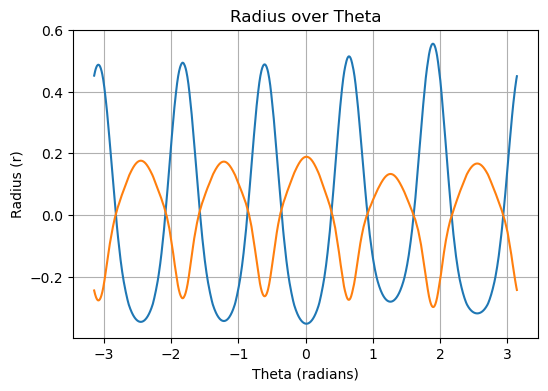

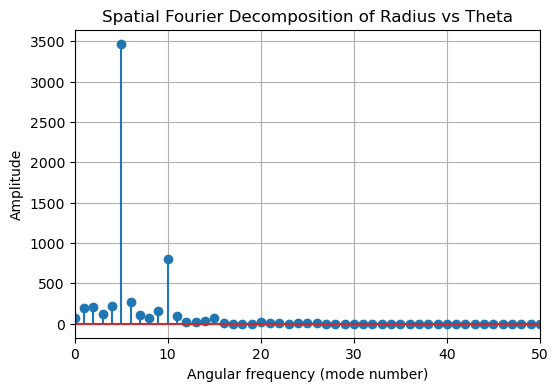

Shape seems to be 5-sided


In [23]:
username = os.getlogin()
filepath = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results/base_18.4k_phi_0.6/Uin_01.50_RUN01/database/Isotherm_t_50.00.okc")
#filepath = r'C:\Users\flori\OneDrive - ETH Zurich\Semester 10\Master Thesis\Sim results\base_18.4k_phi_0.6\Uin_01.90_RUN01\database\Isotherm_t_200.00.okc'
# Usage
df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
#df.plot.scatter(x='x', y='y')
theta_unsorted, r_unsorted, r_fluc_unsorted = cartesian_df_to_polar(df)
velocity_mag_unsorted = np.sqrt(df['x_velocity'].values ** 2 + df['y_velocity'].values ** 2)

# Get the indices that would sort theta
sorted_indices = np.argsort(theta_unsorted)

# Apply the sorting to the arrays
theta = theta_unsorted[sorted_indices]
r = r_unsorted[sorted_indices]
r_fluc = r_fluc_unsorted[sorted_indices]
velocity_mag = velocity_mag_unsorted[sorted_indices]
vel_mag_fluc = velocity_mag - np.mean(velocity_mag)

#fig, ax1 = plt.subplots()
# Plot r vs. theta
plt.figure(figsize=(6, 4))
plt.plot(theta, r_fluc)
plt.plot(theta, vel_mag_fluc)
plt.xlabel('Theta (radians)')
plt.ylabel('Radius (r)')
plt.title('Radius over Theta')
plt.grid(True)
plt.show()
# # Create second y-axis sharing the same x-axis
# ax2 = ax1.twinx()

# # Plot second variable
# ax2.plot(theta, velocity_mag, 'r--', label='log(x + 1)')
# ax2.set_ylabel('log(x + 1)', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

r_fluc_omega, r_fluc_amp = interpolated_FFT(theta, r_fluc)

# Plot the spectrum
plt.figure(figsize=(6, 4))
plt.stem(r_fluc_omega, r_fluc_amp) # use_line_collection=True
plt.xlabel('Angular frequency (mode number)')
plt.ylabel('Amplitude')
plt.title('Spatial Fourier Decomposition of Radius vs Theta')
plt.grid(True)
#plt.xlim(0, len(r_fluc_freq)//2)  # Only positive freqs
plt.xlim(0, 50)
plt.show()

# vel_mag_fluc_omega, vel_mag_fluc_amp = interpolated_FFT(theta, vel_mag_fluc)
# # Plot the spectrum
# plt.figure(figsize=(6, 4))
# plt.stem(vel_mag_fluc_omega,vel_mag_fluc_amp) # use_line_collection=True
# plt.xlabel('Angular frequency (mode number)')
# plt.ylabel('Amplitude')
# plt.title('Spatial Fourier Decomposition of Temperature vs Theta')
# plt.grid(True)
# #plt.xlim(0, len(r_fluc_freq)//2)  # Only positive freqs
# plt.xlim(0, 50)
# plt.show()
dominant_mode = int(r_fluc_omega[np.argmax(r_fluc_amp)])
print(f"Shape seems to be {dominant_mode}-sided")

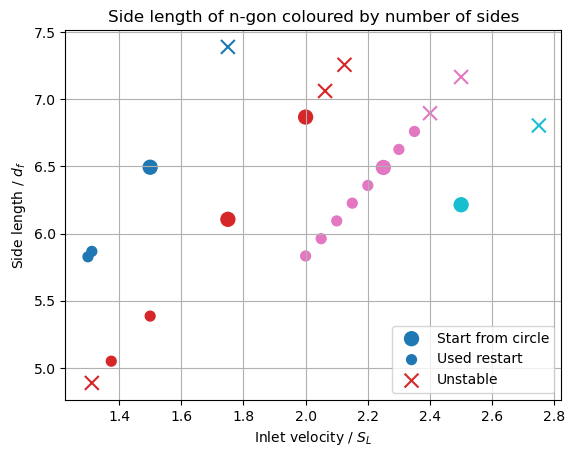

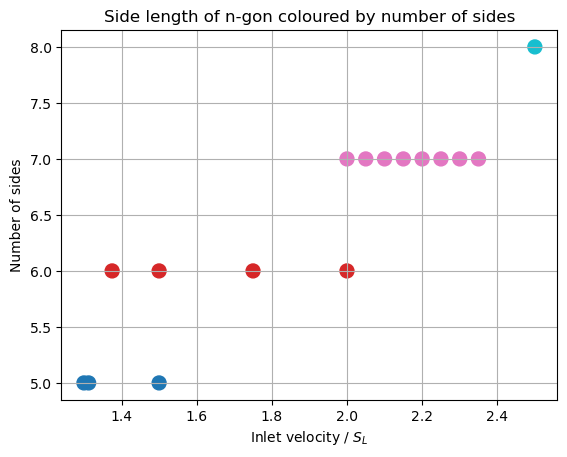

17.25103627841971 6.5684012280012425


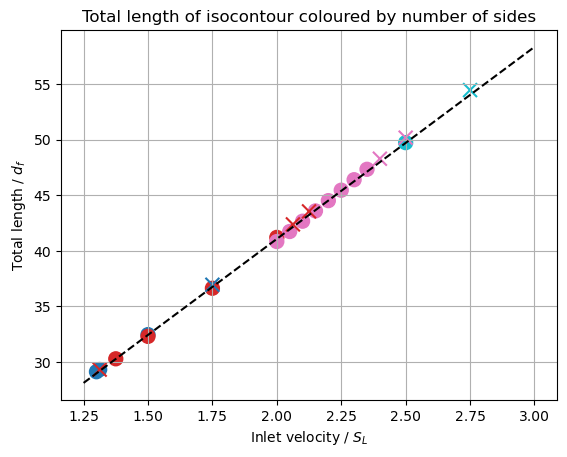

[6.75109387 6.00097233]


In [24]:
username = os.getlogin()
case1 = "base_18.4k_phi_0.6"
runs = ["01.30_01", "01.3125_03", "01.375_02", "01.50_02", "01.50_03", "01.75_01", "02.00_02", "02.00_06","02.05_01", "02.10_01", 
        "02.15_01", "02.20_01", "02.25_02", "02.30_02", "02.35_01", "02.50_02"]
circle_starts = ["01.50_02", "01.75_01", "02.00_02", "02.25_02", "02.50_02"]
dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1

length_sides = []
num_sides = []
inlet_vels = []
is_nr = []

for run in runs:
    if run in circle_starts:
        is_nr.append(True)
    else:
        is_nr.append(False)

    u_in, run_num = run.split("_")
    run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"

    # find the Isocontour file with the latest time
    db_files_dir = run_dir / "database"
    all_files = os.listdir(db_files_dir)

    # Filter files that match the pattern and extract time
    matches = []
    for f in all_files:
        match = re.match(r"Isotherm_t_(\d+)", f)
        if match:
            time_val = int(match.group(1))
            matches.append((f, time_val))

    # Find the file with the largest time
    if matches:
        final_Isocon = max(matches, key=lambda x: x[1])[0]
    else:
        print("[WARNING] No matching files found.")
    filepath = db_files_dir / final_Isocon
    df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
    theta_unsorted, r_unsorted, r_fluc_unsorted = cartesian_df_to_polar(df)
    velocity_mag_unsorted = np.sqrt(df['x_velocity'].values ** 2 + df['y_velocity'].values ** 2)

    # Get the indices that would sort theta
    sorted_indices = np.argsort(theta_unsorted)
    theta = theta_unsorted[sorted_indices]
    r = r_unsorted[sorted_indices]
    r_fluc = r_fluc_unsorted[sorted_indices]
    
    _num_sides = get_dominant_mode(theta, r_fluc)
    num_sides.append(_num_sides)
    inlet_vels.append(float(u_in)) 
    #df = extract_fields_from_okc(run_dir, ['x', 'y', 'x_velocity', 'y_velocity'])
    filepath = run_dir / "timeseries_meanvel_len.csv"
    timeseries = pd.read_csv(filepath, sep=r'\s+')
    total_length = float(timeseries['total_length'].iloc[-1])
    length_sides.append(total_length / _num_sides)

length_sides = np.array(length_sides)
num_sides = np.array(num_sides)
inlet_vels =np.array(inlet_vels)
is_nr = np.array(is_nr)

df = pd.read_csv(f"unstable_cases.csv", skipinitialspace=True)
inlet_vels_us = df['u_in'].values
num_sides_us = df['num_side'].values
tot_length_us = df['l_tot'].values

# Define shared color range
vmin = num_sides.min()
vmax = num_sides.max()
plt.scatter(inlet_vels[is_nr], length_sides[is_nr], c=num_sides[is_nr], cmap='tab10', 
            vmin=vmin, vmax=vmax, s=100, marker='o', label='Start from circle')
plt.scatter(inlet_vels[~is_nr], length_sides[~is_nr], c=num_sides[~is_nr], cmap='tab10', 
            vmin=vmin, vmax=vmax, s=50, marker='o', label='Used restart')
plt.scatter(inlet_vels_us, tot_length_us/num_sides_us, c=num_sides_us, cmap='tab10', 
            vmin=vmin, vmax=vmax, s=100, marker='x', label='Unstable')
plt.xlabel("Inlet velocity / $S_L$")
plt.ylabel("Side length / $d_f$")
plt.title("Side length of n-gon coloured by number of sides")
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(inlet_vels, num_sides, c=num_sides, cmap='tab10', s=100, marker='o')
plt.xlabel("Inlet velocity / $S_L$")
plt.ylabel("Number of sides")
plt.title("Side length of n-gon coloured by number of sides")
#plt.legend()
plt.grid(True)
plt.show()

plt.scatter(inlet_vels, num_sides * length_sides, c=num_sides, cmap='tab10', s=100, marker='o')
plt.scatter(inlet_vels_us, tot_length_us, c=num_sides_us, cmap='tab10', s=100, marker='x')
plt.xlabel("Inlet velocity / $S_L$")
plt.ylabel("Total length / $d_f$")
plt.title("Total length of isocontour coloured by number of sides")
#plt.legend()
plt.grid(True)
l_slope, l_intercept, r_value, p_value, std_err = linregress(inlet_vels, num_sides * length_sides)
#x_fit = np.linspace(min(inlet_vels), max(inlet_vels), 100)
x_fit = np.linspace(1.25, 3.0, 100)
y_fit = l_slope * x_fit + l_intercept
y_pred = 3 * x_fit
plt.plot(x_fit, y_fit, color='black', label='Fit', linestyle='--')
print(l_slope, l_intercept)
#plt.plot(x_fit, y_pred, color='blue', label='Fit')
plt.show()
print((2.75*l_slope + l_intercept)/[8, 9])

def predict_shape(u_in, slope, intercept):
    l_tot_pred = u_in * slope + intercept
    num_sides = []
    l_sides = []
    for num_side in range(4,10):
        l_side = l_tot_pred / num_side
        if l_side > 5.8 and l_side < 6.8:
            num_sides.append(num_side)
            l_sides.append(l_side)
    print(num_sides)
    print(l_sides)


In [25]:
username = os.getlogin()
#case1 = "base_18.4k_phi_0.6"
#case1 = "large_23.6k_phi_0.6"
case1 = "base_18.4k_phi_0.75"
runs = ["01.75_01", "01.75_02"]
#runs = ["01.75_01"]
#runs = ["02.00_01", "02.00_02"]
#runs = ["02.25_01", "02.25_02"]
#runs = ["02.50_01", "02.50_02"]
#runs = ["02.75_02"]
#runs = ["03.00_01"]
#runs = ["10.00_02", "10.00_03"]
#runs = ["01.75_03", "01.75_04", "01.75_05", "01.75_06"]

dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
case_dir = dataset_dir / case1

num_modes = 50
lengths_list = []
amp_time_series_list = []
k_time_series_r_list = []
time_list = []
for run in runs:   
    # Set directories of run
    u_in, run_num = run.split("_")
    run_dir = case_dir / f"Uin_{u_in}_RUN{run_num}"
    db_files_dir = run_dir / "database"

    # Extract the total contour lengths
    filepath = run_dir / "timeseries_meanvel_len.csv"
    timeseries = pd.read_csv(filepath, sep=r'\s+')
    total_lengths  = timeseries['total_length'].values

    # Find all files at different times and create empty arrays
    all_files = np.array(os.listdir(db_files_dir))
    #amp_time_series = np.empty((len(all_files), num_modes))
    #k_time_series = np.empty((len(all_files), num_modes))
    k_time_series_r = np.empty((len(all_files), num_modes))
    amp_time_series_r = np.empty((len(all_files), num_modes))
    time = np.empty((len(all_files)))
    for i, file in enumerate(all_files):
        match = re.match(r"Isotherm_t_(\d+.\d+)", file)
        time_val = float(match.group(1))
        time[i] = time_val

    sorted_indices = np.argsort(time)
    time = time[sorted_indices]
    all_files = all_files[sorted_indices]
    for i, file in enumerate(all_files):
        # Extract time of file and read file
        #match = re.match(r"Isotherm_t_(\d+.\d+)", file)
        #print(float(match.group(1)))
        filepath = db_files_dir / file
        df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
        theta_unsorted, r_unsorted, r_fluc_unsorted = cartesian_df_to_polar(df)

        # Sort arrays by theta
        sorted_indices = np.argsort(theta_unsorted)
        theta = theta_unsorted[sorted_indices]
        r = r_unsorted[sorted_indices]
        r_fluc = r_fluc_unsorted[sorted_indices]
        
        # Extract the amplitude of the first n dominant modes at that timestep
        #r_fluc_k, r_fluc_amp = interpolated_FFT(theta, r_fluc)
        #amp_time_series[i,:] = r_fluc_amp[1:num_modes+1]
        #k_time_series[i] = r_fluc_k[1:num_modes+1]
        

        r_fluc_k_r, r_fluc_amp_r = interpolated_FFT(theta / (2*np.pi) * total_lengths[i], r_fluc)
        amp_time_series_r[i] = r_fluc_amp_r[1:num_modes+1]
        k_time_series_r[i,:] = r_fluc_k_r[1:num_modes+1]

     
    lengths_list.append(total_lengths)
    time_list.append(time)
    amp_time_series_list.append(amp_time_series_r)
    k_time_series_r_list.append(k_time_series_r)

lengths_tot = np.concatenate(lengths_list)
time_tot = np.concatenate(time_list)
amp_tot = np.concatenate(amp_time_series_list)
k_r_tot = np.concatenate(k_time_series_r_list)

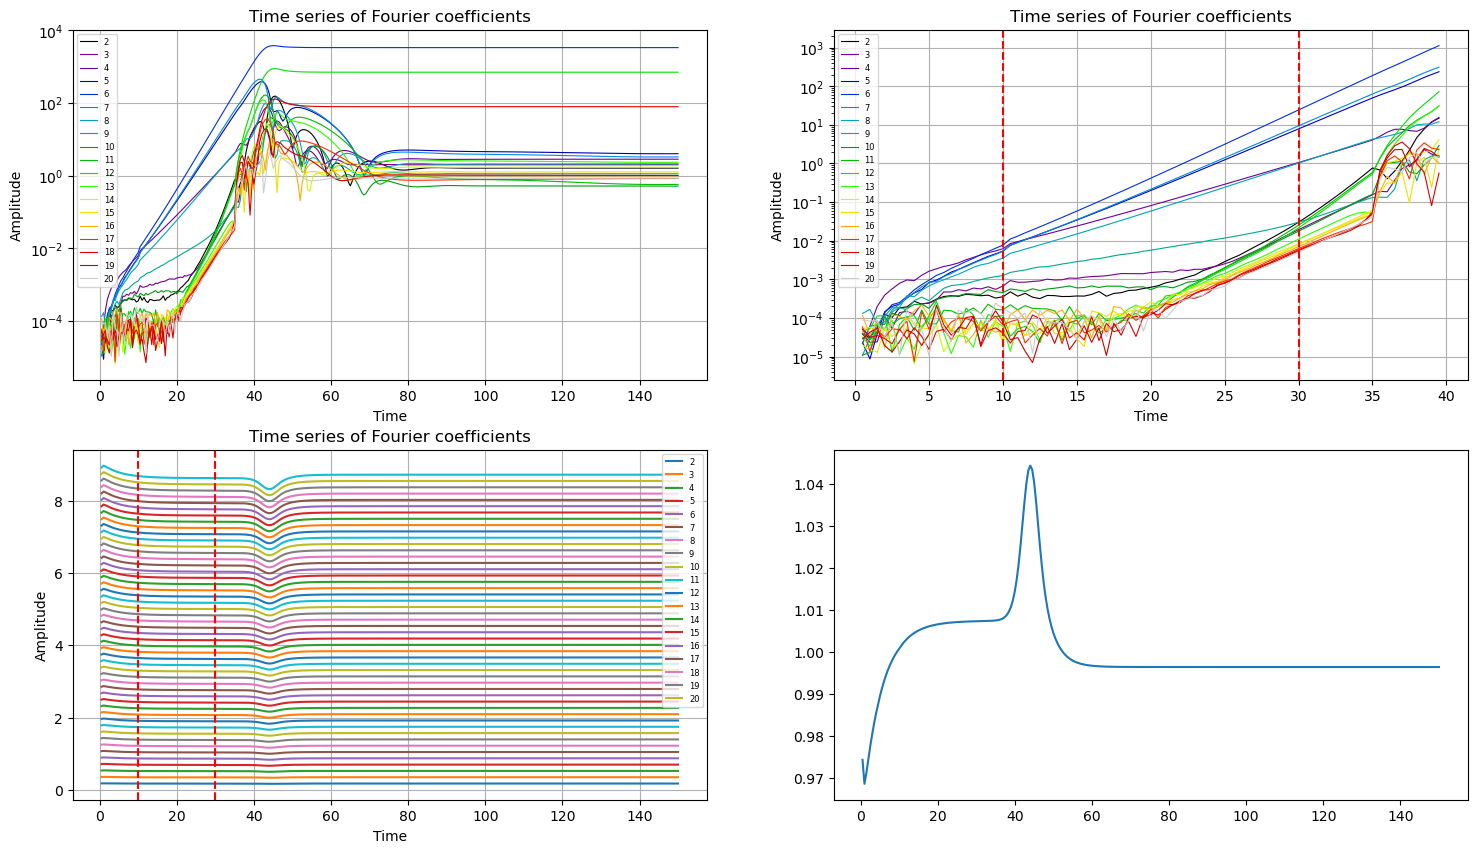

0.249	0.696	0.0065
0.357	0.869	0.0065
0.397	1.043	0.0065
0.368	1.217	0.0065
0.277	1.391	0.0065
0.146	1.565	0.0065


In [26]:
# Extract dispersion relation
plt_s = slice(1, 20)
#modes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13] # Mode n-1
modes = list(range(3, 9))
t_start = 10
t_end = 30
t_start_ind = closest_index = np.argmin(np.abs(time_tot - t_start))
t_end_ind = closest_index = np.argmin(np.abs(time_tot - t_end))

my_cmap = plt.get_cmap('nipy_spectral')
colors = my_cmap(np.linspace(0, 1, (plt_s.stop - plt_s.start)))

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
for i in range(plt_s.start, plt_s.stop):
    axes[0, 0].semilogy(time_tot, amp_tot[:,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
#axes[0, 0].stem(np.linspace(1,10,10), amp_time_series[50])
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Time series of Fourier coefficients')
axes[0, 0].grid(True)
axes[0, 0].legend(prop={'size': 6})

for i in range(plt_s.start, plt_s.stop):
    axes[0, 1].semilogy(time_tot[max(0, t_start_ind-20):t_end_ind+20], amp_tot[max(0, t_start_ind-20):t_end_ind+20,i], color=colors[i-plt_s.start], label=str(i+1), linewidth=0.8)
#axes[0, 1].semilogy(time_tot[70:76], amp_tot[70:76,2:])
axes[0, 1].axvline(x=t_start, color='red', linestyle='--')
axes[0, 1].axvline(x=t_end, color='red', linestyle='--')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Time series of Fourier coefficients')
axes[0, 1].grid(True)
axes[0, 1].legend(prop={'size': 6})

axes[1, 0].plot(time_tot, k_r_tot)
axes[1, 0].axvline(x=t_start, color='red', linestyle='--')
axes[1, 0].axvline(x=t_end, color='red', linestyle='--')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].set_title('Time series of Fourier coefficients')
axes[1, 0].grid(True)
axes[1, 0].legend([str(i+1) for i in range(plt_s.start, plt_s.stop)], prop={'size': 6})

axes[1, 1].plot(time_tot, lengths_tot/np.mean(lengths_tot))

plt.show()


#print(f"omega   k   rel change k")
log_modes = np.log(amp_tot[:,modes])
for i in range(log_modes.shape[1]):
    slope, intercept, r_value, p_value, std_err = linregress(time_tot[t_start_ind:t_end_ind], log_modes[t_start_ind:t_end_ind, i])
    k_mean = np.mean(k_r_tot[t_start:t_end, modes[i]])
    k_rel_err = (k_r_tot[t_end_ind, modes[i]] - k_r_tot[t_start_ind, modes[i]]) / k_r_tot[t_start_ind, modes[i]]
    print(f"{slope:.3f}\t{k_mean:.3f}\t{abs(k_rel_err):.4f}")

# print(amp_tot[72,2:]-amp_tot[71,2:])
# print(amp_tot[70,2:]-amp_tot[69,2:])
# print((amp_tot[72,2:]-amp_tot[71,2:])-(amp_tot[70,2:]-amp_tot[50,2:])/20)

In [27]:
a = np.array([1,2,3])
a = a[np.array([1,1,1])]
plot_slice= slice(1,5)
# for i in range(*plot_slice.indices(1)):
#     print(i)
print(plot_slice.indices(0))

(0, 0, 1)


['Isotherm_t_0.25.okc', 'Isotherm_t_0.50.okc', 'Isotherm_t_0.75.okc', 'Isotherm_t_1.00.okc', 'Isotherm_t_1.25.okc', 'Isotherm_t_1.50.okc', 'Isotherm_t_1.75.okc', 'Isotherm_t_10.00.okc', 'Isotherm_t_10.25.okc', 'Isotherm_t_10.50.okc', 'Isotherm_t_10.75.okc', 'Isotherm_t_11.00.okc', 'Isotherm_t_11.25.okc', 'Isotherm_t_11.50.okc', 'Isotherm_t_11.75.okc', 'Isotherm_t_12.00.okc', 'Isotherm_t_12.25.okc', 'Isotherm_t_12.50.okc', 'Isotherm_t_12.75.okc', 'Isotherm_t_13.00.okc', 'Isotherm_t_13.25.okc', 'Isotherm_t_13.50.okc', 'Isotherm_t_13.75.okc', 'Isotherm_t_14.00.okc', 'Isotherm_t_14.25.okc', 'Isotherm_t_14.50.okc', 'Isotherm_t_14.75.okc', 'Isotherm_t_15.00.okc', 'Isotherm_t_15.25.okc', 'Isotherm_t_15.50.okc', 'Isotherm_t_15.75.okc', 'Isotherm_t_16.00.okc', 'Isotherm_t_16.25.okc', 'Isotherm_t_16.50.okc', 'Isotherm_t_16.75.okc', 'Isotherm_t_17.00.okc', 'Isotherm_t_17.25.okc', 'Isotherm_t_17.50.okc', 'Isotherm_t_17.75.okc', 'Isotherm_t_18.00.okc', 'Isotherm_t_18.25.okc', 'Isotherm_t_18.50.okc'

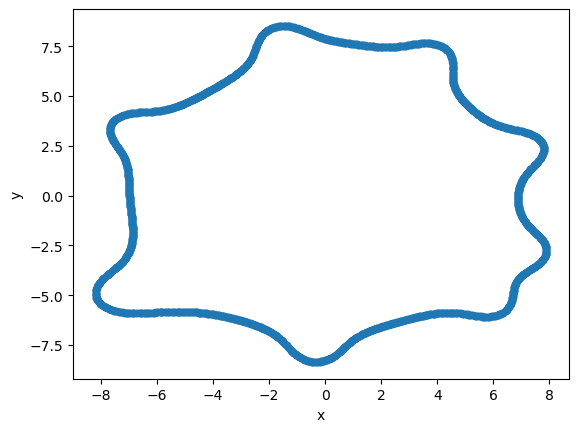

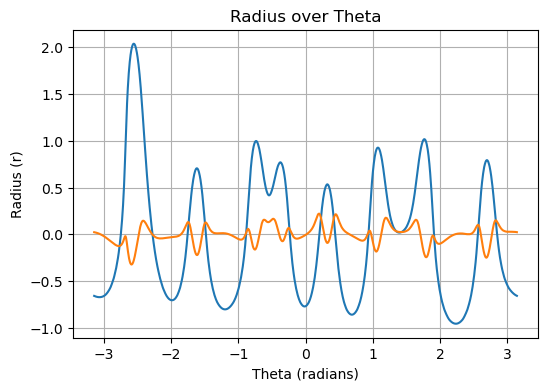

In [28]:
username = os.getlogin()
case1 = "base_18.4k_phi_0.6"
runs = "Uin_02.75_RUN02"
circle_starts = ["01.50_02", "01.75_01", "02.00_02", "02.25_02", "02.50_02"]
dataset_dir = Path(f"C:/Users/{username}/OneDrive - ETH Zurich/Semester 10/Master Thesis/Sim results")
run_dir = dataset_dir / case1 / runs / "database"

files = os.listdir(run_dir)
filepath = run_dir / "Isotherm_t_40.00.okc"
print(files)
df = extract_fields_from_okc(filepath, ['x', 'y', 'x_velocity', 'y_velocity'])
df.plot.scatter(x='x', y='y')
theta_unsorted, r_unsorted, r_fluc_unsorted = cartesian_df_to_polar(df)
velocity_mag_unsorted = np.sqrt(df['x_velocity'].values ** 2 + df['y_velocity'].values ** 2)

# Get the indices that would sort theta
sorted_indices = np.argsort(theta_unsorted)

# Apply the sorting to the arrays
theta = theta_unsorted[sorted_indices]
r = r_unsorted[sorted_indices]
r_fluc = r_fluc_unsorted[sorted_indices]
velocity_mag = velocity_mag_unsorted[sorted_indices]
vel_mag_fluc = velocity_mag - np.mean(velocity_mag)

#fig, ax1 = plt.subplots()
# Plot r vs. theta
plt.figure(figsize=(6, 4))
plt.plot(theta, r_fluc)
plt.plot(theta, vel_mag_fluc)
plt.xlabel('Theta (radians)')
plt.ylabel('Radius (r)')
plt.title('Radius over Theta')
plt.grid(True)
plt.show()